In [1]:
%matplotlib inline

import os
import glob
import json
import time
import copy
import pickle
import datetime

import bcolz
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from IPython.display import display

import utils
import config

In [2]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [3]:
def csv_predictions_to_array(path):
    frame = pd.read_csv(path)
    d = {}
    for index, row in frame.iterrows():
        d[row['image']] = np.array(row[classes], dtype=np.float32)
    return np.array([d[k] for k in sorted(d)])


def create_rect_xywh(box, color='red'):
    return plt.Rectangle((box[0], box[1]), box[2], box[3],
                         color=color, fill=False, linewidth=2)

def plot(img):
    x = copy.copy(img)
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    plt.imshow(np.array(x, dtype=np.uint8))

In [4]:
index = 0
info_string = 'fish'
prefix = os.path.join('cache', info_string + '_' + str(index))

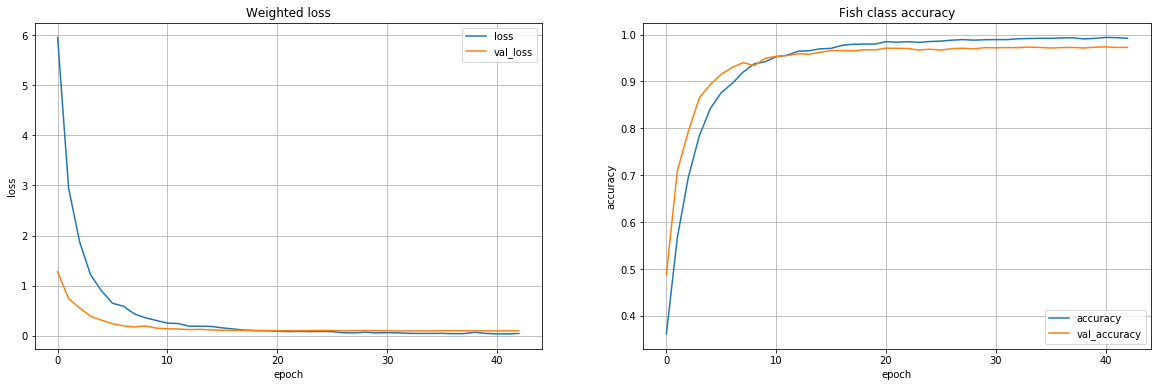

In [5]:
history = pickle.load(open(prefix + '_history.p', 'rb'))

plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.title('Weighted loss')
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(122)
plt.title('Fish class accuracy')
plt.plot(history['acc'], label='accuracy')
plt.plot(history['val_acc'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.show()

In [88]:
result = 'cache/fish_0_2017-02-14-17-49.csv'
real = csv_predictions_to_array('test_stg1.csv')
pred = csv_predictions_to_array(result)

def do_clip(arr, mx):
    clipped = np.clip(arr, (1-mx)/1, mx)
    return clipped/clipped.sum(axis=1)[:, np.newaxis]

diff = 0
for i in range(len(real)):
    if np.argmax(real[i]) != np.argmax(pred[i]):
        diff += 1

print('Diff:', diff)
print('Log loss:', log_loss(real, pred))
print('Clipped log loss:', log_loss(real, do_clip(pred, 0.97)))

def clip(x):
    mx = 0.96
    clipped = np.clip(x.values, (1 - mx) / 1, mx)
    clipped /= clipped.sum()
    return clipped

frame = pd.read_csv(result)
frame[classes] = frame[classes].apply(clip, axis=1)
frame.to_csv('cache/clipped_' + os.path.basename(result), index=False)

Diff: 284
Log loss: 1.35498732067
Clipped log loss: 0.975263989344


In [80]:
test_images = utils.load_array('test_stg1_images.bc')
test_ids = utils.load_array('test_stg1_ids.bc')
test_bboxes = utils.load_array('y_test_bbox.bc')

print('test_images:', np.shape(test_images))
print('test_ids:', np.shape(test_ids))
print('test_bboxes:', np.shape(test_bboxes))

test_ids_argsort = np.argsort(test_ids)

def show_pred(i, bb=False):
    plt.figure(figsize=(9, 12))
    plt.imshow(test_images[test_ids_argsort[i]])
    
    ax = plt.gca()
    print('Filename:', test_ids[test_ids_argsort[i]])
    idx = int(i / (config.augmentation_factor + 1))
    p = pred[idx]
    print('Pred: {} ({:.3f})'.format(classes[np.argmax(p)], p[np.argmax(p)]))
    print('Real:', classes[np.argmax(real[idx])])
    if bb:
        box = test_bboxes[test_ids[test_ids_argsort[i]]]
        print('Box (x,y,w,h): ', box)
        if box[2] > 0 and box[3] > 0:
            ax.add_patch(create_rect_xywh(box, 'yellow'))

test_images: (6000, 448, 448, 3)
test_ids: (6000,)
test_bboxes: (0,)


Filename: img_05241.jpg
Pred: OTHER (0.722)
Real: OTHER


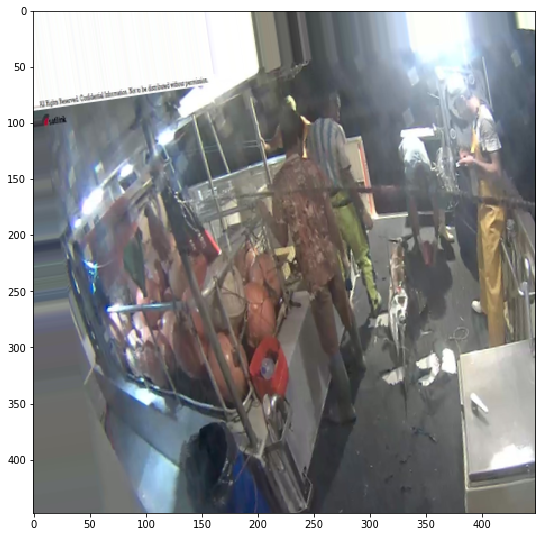

In [89]:
show_pred(3902)

In [90]:
pred_p = {}
real_p = {}
for i in range(len(classes)):
    pred_p[classes[i]] = 0
    real_p[classes[i]] = 0

total = 0
for i in range(len(pred)):
    for j in range(len(classes)):
        pred_p[classes[j]] += pred[i][j]
        real_p[classes[j]] += real[i][j]

for i in range(len(classes)):
    pp = pred_p[classes[i]] / len(pred) * 100.0
    rp = real_p[classes[i]] / len(pred) * 100.0
    print('{}\tpred: {:.2f}%\treal: {:.2f}%\tbias: {:.3f}'.format(classes[i], pp, rp, pp/rp))

ALB	pred: 48.47%	real: 51.50%	bias: 0.941
BET	pred: 5.06%	real: 6.20%	bias: 0.816
DOL	pred: 2.07%	real: 1.60%	bias: 1.295
LAG	pred: 3.39%	real: 3.70%	bias: 0.917
NoF	pred: 16.20%	real: 12.20%	bias: 1.328
OTHER	pred: 7.04%	real: 8.20%	bias: 0.859
SHARK	pred: 2.24%	real: 3.00%	bias: 0.747
YFT	pred: 15.52%	real: 13.60%	bias: 1.141


In [91]:
c_matrix = {}
p_matrix = {
    'TP': {},
    'FP': {},
    'FN': {},
    'TN': {},
    'ACC': {},
    'REC': {},
    'PRE': {},
    'F1': {}
}

for i in range(len(classes)):
    tl = classes[i] + '_T'
    c_matrix[tl] = {}
    for j in range(len(classes)):
        pl = classes[j] + '_P'
        c_matrix[tl][pl] = 0

for i in range(len(classes)):
    cn = classes[i]
    p_matrix['TP'][cn] = 0
    p_matrix['FP'][cn] = 0
    p_matrix['FN'][cn] = 0
    p_matrix['TN'][cn] = 0
    p_matrix['ACC'][cn] = 0
    p_matrix['REC'][cn] = 0
    p_matrix['PRE'][cn] = 0
    p_matrix['F1'][cn] = 0
        
for i in range(len(pred)):
    predicted = classes[np.argmax(pred[i])]
    truelabel = classes[np.argmax(real[i])]
    c_matrix[truelabel + '_T'][predicted + '_P'] += 1
    
    if predicted == truelabel:
        p_matrix['TP'][predicted] += 1
    else:
        p_matrix['FP'][predicted] += 1
        p_matrix['FN'][truelabel] += 1

for i in range(len(classes)):
    cn = classes[i]
    tp = int(p_matrix['TP'][cn])
    fn = int(p_matrix['FN'][cn])
    fp = int(p_matrix['FP'][cn])
    tn = p_matrix['TN'][cn] = len(pred) - (tp + fn + fp)
    p_matrix['ACC'][cn] = (tp + tn) / (tp + tn + fp + fn)
    r = p_matrix['REC'][cn] = tp / (tp + fn)
    p = p_matrix['PRE'][cn] = tp / (tp + fp)
    p_matrix['F1'][cn] = 2 * (p * r) / (p + r)

#pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame(c_matrix))
display(pd.DataFrame(p_matrix)[['TP', 'FP', 'TN', 'FN', 'PRE', 'REC', 'F1', 'ACC']])

,ALB_T,BET_T,DOL_T,LAG_T,NoF_T,OTHER_T,SHARK_T,YFT_T
ALB_P,421,31,0,0,5,23,3,29
BET_P,17,10,3,4,1,1,6,4
DOL_P,3,0,7,1,0,3,0,7
LAG_P,5,0,0,24,0,0,0,1
NoF_P,33,1,0,0,115,3,7,2
OTHER_P,11,4,0,3,1,38,0,3
SHARK_P,1,0,0,0,0,0,14,3
YFT_P,24,16,6,5,0,14,0,87


,TP,FP,TN,FN,PRE,REC,F1,ACC
ALB,421,91,394,94,0.822266,0.817476,0.819864,0.815
BET,10,36,902,52,0.217391,0.161290,0.185185,0.912
DOL,7,14,970,9,0.333333,0.437500,0.378378,0.977
LAG,24,6,957,13,0.800000,0.648649,0.716418,0.981
NoF,115,46,832,7,0.714286,0.942623,0.812721,0.947
OTHER,38,22,896,44,0.633333,0.463415,0.535211,0.934
SHARK,14,4,966,16,0.777778,0.466667,0.583333,0.980
YFT,87,65,799,49,0.572368,0.639706,0.604167,0.886
